#Reconstruction of palaeotopography from low-temperature thermochronological data

This notebook compares a 2D numerical-simulation to the quasi-analytic solution for isotherm perturbation, given by Wang Wei* and Zhou Zuyi: "Reconstruction of palaeotopography from low-temperature thermochronological data"

##quasi-analytic model

Because heat conduction in solids can be approximated as a linear physical process, the total perturbation of the thermal field caused by the topography can be adequately approximated by the sum of the perturbations caused by each of the components of the Fourier series. The perturbation caused by a periodic topography with small amplitude has been shown to be proportional to the amplitude of the topography, and to decay exponentially with depth (Turcotte et al. 1982). The steady-state solution for topography of constant geometry can therefore be expressed as



$$T(x,y) = T_0(y) + \sum_{n=0}^{N} \left[ 
   a_{n}\,\cos \left(\frac{2n\pi x}{\lambda} \right) \\
   + b_{n} \,\sin \left(\frac{2n\pi x}{\lambda}\right) \right] e^{ym_n} \left(\frac{\partial T_0(y)}{\partial y_{y=0}} - \phi\right)$$
   
Where

$$m_n = \frac{1}{2} \left(-u/k - \sqrt{(u/k)^2 + (4n \pi/\lambda)^2}  \right)$$

$\lambda$ is the width of the domain

$\lambda/n$ is the wavelength of the perturbation

$u$ is exhumation rate

$k$ is thermal diffusivity

$\phi$ is the lapse rate

$T_0(y)$ describes the geotherm with erosion at a steady rate, in the absence of any surface perturbations, and can be fixed according to the temperature at the surface and at the lower boundary of a slab

$$T_0(y) = T_s + \beta\left[1-\exp\left(-\frac{y}{h}\right) \right] + \gamma\left[1-\exp\left(-\frac{u}{\kappa}y\right) \right]$$

Which in the absence of heat-production ,reduces to:

$$T_0(y) = T_s + \gamma\left[1-\exp\left(-\frac{u}{\kappa}\right) \right]$$

$$\gamma = \frac{(T_L-T_s) - \beta \left[ 1-\exp\left( - \frac{L}{h}\right)\right]}{1-\exp \left(-\frac{u}{k} L\right)}$$

Which in the absence of heat-production ,reduces to:

$$\gamma = \frac{(T_L-T_s)}{1- \exp \left(-\frac{u}{k} L\right)}$$

For a box with surface temperature $T_s$ and constant temperature $T_L$ at depth $L$.

$h$ is the depth at which the heat production drops to
$1/e$ of the surface value $A_s$  (we don't need these parameters for no heat production).


In [983]:
%pylab inline
import math



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [875]:
##Key Parameters (similar to ....Wei & Zuyi)

#basal temp

TL = 2500.

Tmsl = 25. #rough average mean sea level temp for Bhutan Lat.


res = 1.  #Resolution in Kms, will dictate interpolation as well as UW resolution. 

#UW resolution, points for topographic interpolation

L = 100.  #This is the vertical length (depth) in the model, 
#amp = 1.
wavelength = 30.

#exhumation / denudation  (0- 0.5 km / Ma)
u = 0.2
lapse = -4.5 #C/km
DTDY = 25.

#thermal diffusivity km^2 Ma-1 conversion used is 1m^2 s-2 = (365*24*3600)km^2 Ma-1
kappa = 1e-6*(365*24*3600)
kappa


31.535999999999998

##DFT refresher

There often seems to be differing notation regarding where the normalization factor $1/N$ goes. I referred to the notes here: http://www.nbtwiki.net/doku.php?id=tutorial:the_discrete_fourier_transformation_dft#.VgD33p2qqko and http://www.whydomath.org/node/hearing/discreteFourierTransform.html

This definition seems to be appropriate for the scipy FFT module, as shown bewlow where the original signal is synthesised in terms of the sin and cosine terms. 

Using $x$ for the spatial coordinate, and $n$ the coordinate of the transform pair (as in Wang Wei* and Zhou Zuyi:),  The discrete Fourier transform is given by:

$$ F_n = \sum_{x=0}^{N-1} f_x e^{-2\pi i x n / N}$$ 

the inverse transform is:

$$ f_x = \frac{1}{N} \sum_{n=0}^{N-1} F_n e^{2\pi i x n / N}$$ 

The longest full sinusoidal cycle that can be captured by the N data points consists of N samples per cycle. The smalles frequency above zero in the DFT is the reciprocal, $f_1 = 1/N$ cycles per sample


0.0

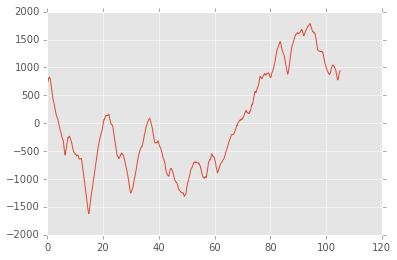

In [1313]:
#topolist = []
#amp = 1.
#xlist = np.arange(0, W, 1)
#xlist = np.array(horizontals)


#topo = amp*(np.sin(2. * np.pi * xlist/(wavelength))) + 0.5 * np.random.randn(xlist.size)


topo= np.loadtxt('topoh.csv', skiprows=1,delimiter=',')
origtopo = np.copy(topo)

mean_elv = topo[:,2].mean()
max_elv = topo[:,2].max()
min_elv = topo[:,2].min()
topo[:,2] -= abs(topo[:,2].mean())
dom_width = topo[:,0].max() - topo[:,0].min()
pyplot.plot(topo[:,0],topo[:,2])

In [877]:
topo[:,2]

array([ 699.79983512,  700.20396112,  700.56139612, ...,  938.70112012,
        939.35130512,  940.19034612])

##########
#if sythetic topography is wanted
##########
synamp = 1500.0
sytwl = 15.
syntop =[synamp* (math.cos((2*math.pi*(x))/sytwl)) for x in topo[:,0]]
topo[:,2] =syntop
#mean_elv = topo[:,2].mean()
max_elv = topo[:,2].max()
min_elv = topo[:,2].min()

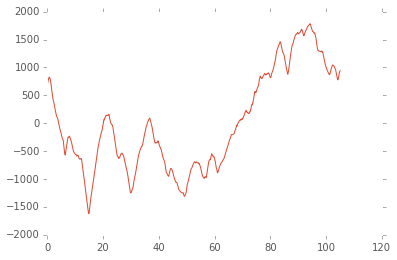

In [878]:
pyplot.plot(topo[:,0],topo[:,2])

In [879]:
print(min_elv, mean_elv,max_elv)

(749.13131910000004, 2369.8921038768931, 4153.8195910000004)


In [880]:
#Set the model domain width, number of points in interpolated topography, FFT, UW elements
W = topo[:,0].max()
npts = int(np.ceil(W/res))

#Set the temperature at the mean elevation
TS = Tmsl  + lapse*mean_elv/1e3
print(TS)

14.3354855326


In [881]:
dom_width

105.00042089999999

In [882]:
from scipy.interpolate import interp1d

In [883]:
#topo[:,0].max() - topo[:,0].min()
elev = interp1d(topo[:,0], topo[:,2])
newx = np.linspace(topo[:,0].min(), topo[:,0].max(), npts)
newy = elev(newx)/1000.
#newy -= abs(newy.min())

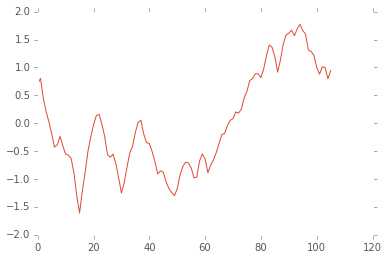

In [884]:
pyplot.plot(newx,newy)

In [885]:
from scipy import fftpack
sample_freq = fftpack.fftfreq(newy.size, d=1)
sig_fft = fftpack.fft(newy)

#trunc = 50.
yinv = fftpack.ifft(sig_fft)

In [886]:
sig_fft.shape

(106,)

In [887]:
# synthesise the signal using cos and sin
def synth(ffcs, freqs=False):
    """
    experimental function to test the FFT conventions in Scipy, 
    A (complex valued) ffcs object is synthesised using addition of sin and cosines (Euler's formula)
    par "freqs" can be added to reduce the number of terms in the synthesis
    """
    x = []
    N = len(ffcs)
    #N = (topo[:,0].max() - topo[:,0].min()
    #print a0
    if not freqs:
        freqs = len(ffcs)
    for k in range(freqs):
        xk = [(1./N)*((np.real(ffcs[k])*np.cos((2.*np.pi*n*k)/(N))) - np.imag(ffcs[k])*np.sin((2.*np.pi*n*k)/(N))) for n in range(N)]
        #xk.append(v)   
        x.append(xk)
    arr = np.array(x)
    return np.sum(arr, axis = 0.)

In [888]:
toposynth1 = synth(sig_fft, freqs = 1)
toposynth = synth(sig_fft)

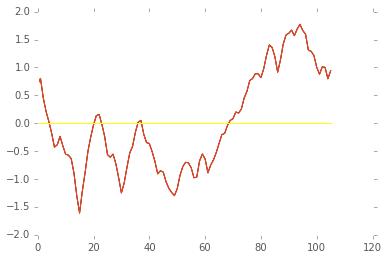

In [889]:
pyplot.plot(newx, newy, color="green")
pyplot.plot(newx, yinv, color="red")
pyplot.plot(newx, toposynth)
pyplot.plot(newx, toposynth1, color='yellow')

In [890]:
def Tflat(y, TL, TS, L, u, kappa, lapse):
    if y < 0:
        t = TS + (-1*y*lapse)
    else:
        gam = (TL-TS)/(1-np.exp(-L*(u/kappa)))
        t = TS + gam*(1-np.exp(-1*(u/kappa)*y))
    return t

In [891]:
#Check Tflat is working (i.e. no topography, no exhumation):
uc = 1e-8
geotherm=(TL-TS)/L
print(geotherm)
depth = 10.
expected = TS + depth*geotherm
result = Tflat(depth, TL, TS, L, uc, kappa, lapse)
print(expected, result)

24.8566451447
(262.90193697929863, 262.90193697929863)


In [892]:
 def analytic_geotherm(y,width, ffcs, TL, TS, L, u, kappa,dtdy,lapse):
    #######
    #Get T0
    #######
    #gam = (TL-TS)/(1-np.exp(-L*(u/kappa)))
    #T0 = TS + gam*(1-np.exp(-1*(u/kappa)*y))
    T0 = Tflat(y, TL, TS, L, u, kappa, lapse)
    #######
    #Compute pertubation from Fourier coeffcients
    #######
    t = []
    N = len(ffcs)
    for n in range(len(ffcs)):
        mn = 0.5*((-1*u/kappa) - np.sqrt((u/kappa)**2 + ((4*n*np.pi)/(width))**2))
        xk = [(1./N)*((np.real(ffcs[n])*np.cos((2.*np.pi*j*n)/(N))) - np.imag(ffcs[n])*np.sin((2.*np.pi*j*n)/(N))) for j in range(N)]
        #print mn
        expterm = np.exp(mn*y)*(dtdy - lapse)
        temppert = [i*expterm for i in xk]
        t.append(temppert)
    arr = np.array(t)
    tp = np.sum(arr, axis = 0.)
    tp += T0
    return tp


In [893]:
#Create y values for topographic array, x values are taken from the number of samples in the profile
ys = np.linspace(0,6, 100)
a = np.zeros((ys.shape[0] , npts))

In [1568]:
todepth = 4
vertpts = 40.
valley = newy.min()
ys = np.linspace(abs(valley), (todepth + abs(valley)), vertpts)
#xs = np.linspace(0 , W, vertpts*floor((W/todepth)))
#X, Y = np.meshgrid(xs, ys)
temperatures = np.zeros((ys.shape[0] , npts))

In [1569]:
#ys
newy.min()

-1.6094078033077497

In [1570]:
#abs(valley)
todepth + abs(valley)
#(todepth + abs(valley))
#ys.max() - ys.min()

5.6094078033077501

In [1571]:
for index, y in enumerate(ys):
    T = analytic_geotherm(y,dom_width, sig_fft, TL, TS, L, u, kappa, DTDY, lapse)
    temperatures[index,:] = T
    
#Set any negative values of a to zero

a[a < 0] = 0

In [988]:
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
     def __repr__(self):
         str = '%.1f' % (self.__float__(),)
         if str[-1]=='0':
             return '%.0f' % self.__float__()
         else:
             return '%.1f' % self.__float__()

In [1262]:
(origtopo[:,2]/1000.).min() - 4

-3.2508686809

In [1263]:
#Our Fourier expansion is around the Mean elevation. For plotting we want the true elevation
zerolineelev = (origtopo[:,2]/1000.).min()
bottomelev = (origtopo[:,2]/1000.).min() - 4
print(zerolineelev, bottomelev)

(0.74913131910000008, -3.2508686809)


In [990]:
ys[0]

1.6094078033077497

In [991]:
a.max()

312.07990089547263

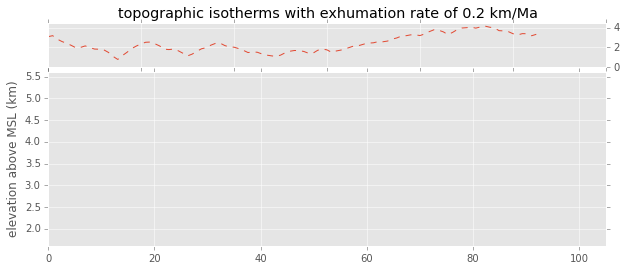

In [1565]:
fig1 = plt.figure(figsize=[10,4])
#
gs = GridSpec(100,400)

axT = fig1.add_subplot(gs[0:20,0:400])
plt.title('topographic isotherms with exhumation rate of ' + str(u) + ' km/Ma')
axT.plot(toposynth+(mean_elv/1e3), '--')
axT.xaxis.set_major_formatter(plt.NullFormatter())
axT.yaxis.tick_right() 
axT.yaxis.set_ticks([0,2,4])
axMain = fig1.add_subplot(gs[22:,0:400])
levels = [80, 100, 150, 200, 300]
CS1 = axMain.contour(flipud(temperatures), levels, extent=[0, dom_width, abs(valley), (todepth + abs(valley))], aspect='auto')
CS1.levels = [nf(val) for val in CS1.levels ]
fmt = '%r' + ' C'
plt.clabel(CS1, CS1.levels, inline=True, fmt=fmt, fontsize=10)
plt.ylabel('elevation above MSL (km)')

    

Figure caption: Figure shows isotherms calculated below the mean topographic level, using the semi-analytic approach of W. WEI & Z. ZUYI. 

In [902]:
#Create y values for topographic array, x values are taken from the number of samples in the profile
ys = np.linspace(0,6, 100)
a = np.zeros((ys.shape[0] , npts))

#loop through different exhumation rates, and plot variation of the 100 degree isotherm 
isotherms = []
exhume_vals = np.linspace(0.01,0.5, 6)
for vel in exhume_vals:
    for index, y in enumerate(ys):
        T = analytic_geotherm(y,dom_width, sig_fft, TL, TS, L, vel, kappa, DTDY, lapse)
        a[index,:] = T
    #Set any negative values of a to zero
    a[a < 0] = 0
    fig = plt.figure()
    CS = plt.contour(flipud(a), levels=[100.], extent=[0, dom_width, -6., 0.], aspect='auto')
    out = CS.collections[0].get_paths()
    arr = out[0].vertices[:,1]
    fig.clf()
    isotherms.append(arr)

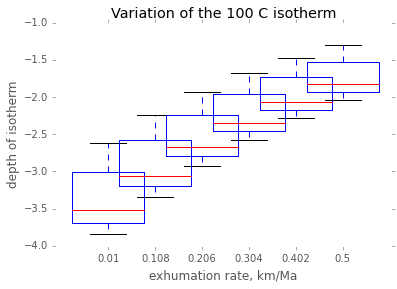

In [903]:
figure(1)
boxplot(isotherms, positions=exhume_vals)
labels = exhume_vals
plt.xlim(-0.1,0.6)
#xticks(range(0,0.5),labels, rotation=15)
xlabel('exhumation rate, km/Ma')
ylabel('depth of isotherm')
title('Variation of the 100 C isotherm')

In [904]:
effective_geotherm = [abs(100./i) for i in isotherms]

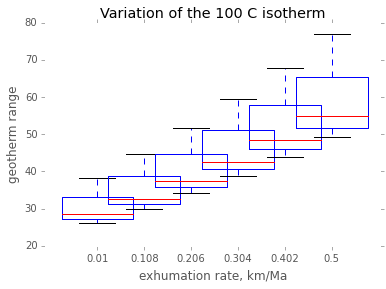

In [905]:
figure(1)
boxplot(effective_geotherm, positions=exhume_vals)
labels = exhume_vals
plt.xlim(-0.1,0.6)
#xticks(range(0,0.5),labels, rotation=15)
xlabel('exhumation rate, km/Ma')
ylabel('geotherm range')
title('Variation of the 100 C isotherm')

##Underworld model

In [906]:
# Stagnant lid convection model

%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import matplotlib.pylab as pyplot
import numpy as np

In [907]:
dim = 2
meshX = int(npts + 1)
meshY = int(L + 1)
maxX = W 
maxY = L


elementMesh = uw.mesh.FeMesh_Cartesian( elementType='Q1/dQ0',
                                      elementRes=(meshX,meshY), 
                                      minCoord=(0.,0.), maxCoord=(maxX,maxY )  )


linearMesh   = elementMesh
constantMesh = elementMesh.subMesh

xCoordFn = fn.input()[0]
yCoordFn = fn.input()[1]

In [908]:
elementMesh.maxCoord
abs(newy.min())

1.6094078033077497

In [909]:
with elementMesh.deform_mesh():
    for index, coord in enumerate(elementMesh.data):
        y0 = coord[1]
        pert = elev(coord[0])/1000.
        elementMesh.data[index][1] = y0 + ((y0/maxY)*pert)

In [910]:
print(elementMesh.maxCoord, elementMesh.data[:,1].max())

((105.00042089999999, 100.0), 101.78339148083158)


In [911]:
coordinate = fn.input()

In [912]:
elev(coord[0])/1000.

0.94019034612310681

In [913]:
dim = 2

# create & zero fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
temperatureField.data[:] = 0.

#Initial Temperature and BCs


In [914]:
toptemp = TS
deltemp = TL

In [915]:
#Initial temperature field is the no-topography solution, extended above/below side of the mean elevation temp (~14 C)

for index, coord in enumerate(elementMesh.data):
    #temperatureField.data[index] = TL
    temperatureField.data[index] = Tflat((maxY - coord[1]), TL, TS, L, u, kappa, lapse)

In [916]:

IWalls = elementMesh.specialSets["MinI_VertexSet"] + elementMesh.specialSets["MaxI_VertexSet"]
JWalls = elementMesh.specialSets["MinJ_VertexSet"] + elementMesh.specialSets["MaxJ_VertexSet"]
# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

In [917]:
#toptemp + deltemp
TL

2500.0

In [918]:
# lets ensure temp boundaries are still what we want as the IC above might have set slightly different values
# on the boundaries
for index in elementMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = TL
for index in elementMesh.specialSets["MaxJ_VertexSet"]:
    elevation = elementMesh.data[index][1]
    dy = elevation - L
    dtemp = TS + dy*lapse
    temperatureField.data[index] = dtemp

In [919]:
topbound = elementMesh.specialSets["MaxJ_VertexSet"]
bottombound = elementMesh.specialSets["MinJ_VertexSet"]
heights = coordinate.evaluate(topbound)[:,1]
horizontals = coordinate.evaluate(topbound)[:,0]

In [920]:
#horizontals.shape

In [921]:
elementMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

In [922]:
#meshfig = plt.Figure()
#meshfig.Mesh(elementMesh, colourBar=False)

#meshfig.show()

In [1586]:
figtemp = plt.Figure()
#figtemp.Surfa                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ce(temperatureField, elementMesh)
figtemp.Mesh(elementMesh, colourBar=False)
figtemp.show()

AttributeError: 'Figure' object has no attribute 'Mesh'

##Setup advection - diffusion system


In [924]:
#Check vertical velocity is still right
print(u)

0.2


In [925]:
velocityField.data[:] = [0,u]
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=kappa, conditions=[tempBC,] )

In [926]:
#print "timestep in years: " + str(advDiff.get_max_dt()*1e6)
#advDiff.get_max_dt()

##Solve

In [927]:
step = 0
areaint = uw.utils.Integral(1.,linearMesh)
area = areaint.integrate()[0]
area

10500.079660363686

In [928]:
dt = 0.001 #thousand years
t0 = temperatureField.copy()
t1 = temperatureField.copy()
tol = 1.
tolcheck = []
realtime = 0.

#while tol > 1e-5:
#while step < 500:
    t0.data[:] = np.copy(temperatureField.data[:])
    #dt = advDiff.get_max_dt()
    advDiff.integrate(dt)
    t1.data[:] = np.copy(temperatureField.data[:])
    intField = t1 - t0
    tempint = uw.utils.Integral(intField, elementMesh)
    tol = tempint.integrate()[0]/area 
    tolcheck.append(tol)
    realtime += dt
    step += 1
    if step % 100 == 0:
        print step, tol
        

100 -0.000127305074901
200 -9.17894100978e-05
300 -7.77186732679e-05
400 -6.9367027597e-05
500 -6.35586950369e-05


##Set up temp-at-depth swarm

* Because the temperature field corresponds to an irregular mesh, we're going to use swarms to interpolate the values at fixed positions

In [1590]:
npts+1
depth = 3

In [1591]:
100 - depth

97

In [1592]:
xps = np.linspace(0, W, npts+2)
yps = np.zeros(npts+2)
yps[:] = 100 - depth #Which corresponds to a depth of L - d.

tempatdepth = uw.swarm.Swarm( feMesh=elementMesh )
tempatdepth.add_particles_with_coordinates(np.array((xps,yps)).T)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107], dtype=int32)

In [1593]:
tempatdepth = temperatureField.evaluate(isoswarm)
tempatdepth.shape

(108, 1)

##Plot underworld vs. Analytic solution at a single depth

In [1594]:
print(depth,dom_width, TL, TS, L, u, kappa, DTDY, lapse)

(3, 105.00042089999999, 2500.0, 14.335485532553982, 100.0, 0.2, 31.535999999999998, 25.0, -4.5)


In [1595]:
#Get the analytic solution and the value in the absence of topography



notop = Tflat(depth, TL, TS, L, u, kappa, lapse)
analytic = analytic_geotherm(depth,dom_width, sig_fft, TL, TS, L, u, kappa, DTDY, lapse)
#data = np.flipud(tempnp[:,:,0])
#numeric = data[depth,:]

In [1596]:
depth

3

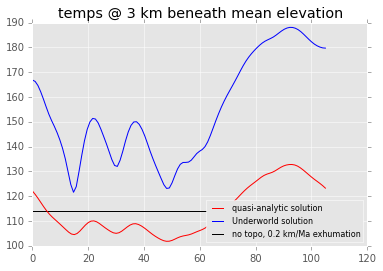

In [1597]:
#data = np.flipud(tempnp[:,:,0])
#for i in depths:
pyplot.title('temps @ ' + str(depth) + ' km beneath mean elevation')

pyplot.plot(newx, analytic, color= "red", label="quasi-analytic solution")
pyplot.plot(horizontals, tempatdepth, color= "blue", label="Underworld solution")
lstr = "no topo, " + str(u) + " km/Ma exhumation" 
pyplot.hlines(notop,0,newx[-1], label=lstr )
pyplot.legend(loc=4, prop={'size':8})
ax = pyplot.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)

#pyplot.savefig('temp@3km.png')


In [1584]:
100 + valley == uwvalley

True

##Create a regular array of Underworld solution, and get isotherms

In [1604]:
uwelevs = []
for index in elementMesh.specialSets["MaxJ_VertexSet"]:
    meshvert = linearMesh.data[index]
    uwelevs.append(meshvert[1])

In [1608]:
print(min(uwelevs), max(uwelevs))

(98.414508690415119, 101.78339148083158)


In [1614]:
uwtemps = []
for index in elementMesh.specialSets["MaxJ_VertexSet"]:
    toptemp = temperatureField.data[index]
    uwtemps.append(toptemp[0])

In [1615]:
print(min(uwtemps), max(uwtemps))

(6.3102238688118604, 21.470196425685948)


In [1616]:
uwvalley = L + newy.min()
ys = np.linspace(min(uwelevs), uwvalley - todepth, vertpts)
xs = np.linspace(0 , W, npts)

In [1617]:
X, Y = np.meshgrid(xs, ys)

In [1618]:
print(Y.shape)

(40, 106)


In [1619]:
depthswarm = uw.swarm.Swarm( feMesh=elementMesh )
depthswarm.add_particles_with_coordinates(np.array((X.ravel(),Y.ravel())).T)

array([   0,    1,    2, ..., 4237, 4238, 4239], dtype=int32)

In [1620]:
regtemps = temperatureField.evaluate(depthswarm)
temperatures2 = regtemps.reshape(ys.shape[0], xs.shape[0])

In [1621]:
zerolineelev = mean_elv/1000. + newy.min()
bottomelev = zerolineelev - todepth

In [1629]:
temperatures3.min()

28.355501808536765

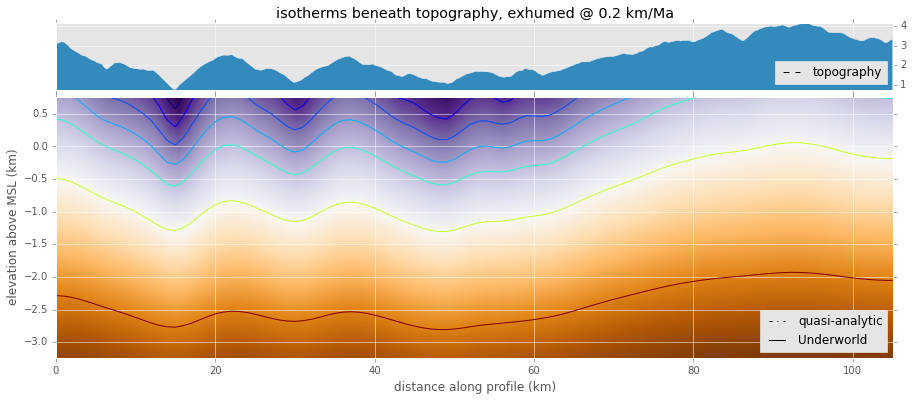

In [1627]:
pyplot.style.use('ggplot')
fig2 = pyplot.figure(figsize=[15,6])
#
gs = GridSpec(100,400)

axT = fig2.add_subplot(gs[0:20,0:400])
axT.set_ylim(origtopo[:,2].min()/1.e3, origtopo[:,2].max()/1.e3)
pyplot.title('isotherms beneath topography, exhumed @ ' + str(u) + ' km/Ma')
tp = origtopo[:,2]/1.e3
axT.plot(origtopo[:,0]/1.e3, tp, '--', c='k')
axT.fill_between(origtopo[:,0], 0, tp)
axT.set_xlim(0, W)

axT.xaxis.set_major_formatter(pyplot.NullFormatter())
axT.yaxis.tick_right() 
axT.yaxis.set_ticks([1,2,3,4])
dummyys = [0. for v in newx]
pyplot.plot(newx,dummyys, linestyle='--', label='topography', c='k')
pyplot.legend(loc=4)


axMain = fig2.add_subplot(gs[22:,0:400])
levels = [40, 60, 80, 100, 120, 160, 240]
plt.imshow(temperatures3.reshape(ys.shape[0], xs.shape[0]), cmap='PuOr_r', aspect='auto', extent=[0, W, bottomelev, abs(zerolineelev)])

#CS1 = axMain.contour(np.flipud(temperatures), levels, aspect='auto',  label='quasi-analystic', extent=[0, W, bottomelev, abs(zerolineelev)], linestyles='dashdot')
CS2 = axMain.contour(np.flipud(temperatures2), levels, aspect='auto',  label='Underworld', extent=[0, W, bottomelev, abs(zerolineelev)])



#CS1 = axMain.contour(flipud(temperatures), levels, extent=[0, W, bottomelev, abs(zerolineelev)], aspect='auto', linestyles='dashdot',label='quasi-analystic')
#CS2 = axMain.contour(flipud(temperatures2), levels, extent=[0, W, bottomelev, abs(zerolineelev)], aspect='auto',  label='Underworld')
CS1.levels = [nf(val) for val in CS1.levels ]
CS2.levels = [nf(val) for val in CS2.levels ]
fmt = '%r' + ' C'

#pyplot.clabel(CS1, CS1.levels, inline=True, fmt=fmt, fontsize=10)
#pyplot.clabel(CS2, CS2.levels, inline=True, fmt=fmt, fontsize=10)

#Dummy lines needed to reveal axis
dummyys = [ bottomelev for v in newx]
pyplot.plot(newx,dummyys, linestyle='dashdot',label='quasi-analytic', c='k')
pyplot.plot(newx,dummyys, label='Underworld', c='k')

pyplot.legend(loc=4)
pyplot.ylabel('elevation above MSL (km)')
pyplot.xlabel('distance along profile (km)')
#pyplot.savefig('bhutan_topo.png')


##Underworld loop for boxplots

* This part assumes you still have live variables from the previous section

In [1521]:
around?

In [1523]:
exhume_vals = np.linspace(0.01,0.5, 6)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

In [1454]:
#elev(out[0].vertices[:,0])

In [1509]:
#loop through different exhumation rates, and plot variation of the 100 degree isotherm 
isotherms2 = []
exhume_vals = np.linspace(0.01,0.5, 6)
for vel in exhume_vals:
    #################
    #Underworld Solve
    #################
    for index, coord in enumerate(elementMesh.data):
        temperatureField.data[index] = Tflat((maxY - coord[1]), TL, TS, L, vel, kappa, lapse)
    velocityField.data[:] = [0,vel]
    # lets ensure temp boundaries are still what we want as the IC above might have set slightly different values
    # on the boundaries
    for index in elementMesh.specialSets["MinJ_VertexSet"]:
        temperatureField.data[index] = TL
    for index in elementMesh.specialSets["MaxJ_VertexSet"]:
        elevation = elementMesh.data[index][1]
        dy = elevation - L
        dtemp = TS + dy*lapse
        temperatureField.data[index] = dtemp
    advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=kappa, conditions=[tempBC,] )
    dt = 0.001 #thousand years
    t0 = temperatureField.copy()
    t1 = temperatureField.copy()
    tol = 1.
    tolcheck = []
    realtime = 0.
    step = 0
    #while tol > 1e-5:
    while step < 500:
        t0.data[:] = np.copy(temperatureField.data[:])
        #dt = advDiff.get_max_dt()
        advDiff.integrate(dt)
        t1.data[:] = np.copy(temperatureField.data[:])
        intField = t1 - t0
        tempint = uw.utils.Integral(intField, elementMesh)
        tol = tempint.integrate()[0]/area 
        tolcheck.append(tol)
        realtime += dt
        step += 1
        if step % 100 == 0:
            print step, tol
    #################
    #Make the data array
    #################
    regtemps = temperatureField.evaluate(depthswarm)
    temperatures3 = regtemps.reshape(ys.shape[0], xs.shape[0])
    #################
    #Get contours
    #################
    fig = plt.figure()
    CS = plt.contour(flipud(temperatures3), levels=[100.], aspect='auto')
    out = CS.collections[0].get_paths()
    #arr = out[0].vertices[:,1]
    #arr = -1*(((out[0].vertices[:,1])/(39./4.)) - (4.-zerolineelev))
    arr = ((elev(out[0].vertices[:,0]) + mean_elv)/1e3) - (((out[0].vertices[:,1])/(39./4.)) - (4.-zerolineelev))
    fig.clf()
    isotherms2.append(arr)

100 -9.69300095906e-05
200 -7.01242574173e-05
300 -5.94261192173e-05
400 -5.30754955906e-05
500 -4.8665426939e-05
100 -0.000112271150589
200 -8.10826597348e-05
300 -6.86821962162e-05
400 -6.13215288938e-05
500 -5.62061370889e-05
100 -0.00012830292263
200 -9.24989005528e-05
300 -7.8317246095e-05
400 -6.98997955585e-05
500 -6.40454152758e-05
100 -0.000144829082528
200 -0.000104227975799
300 -8.82086116033e-05
400 -7.8700966437e-05
500 -7.20830685923e-05
100 -0.000161634980374
200 -0.000116112728216
300 -9.82238780027e-05
400 -8.76073838732e-05
500 -8.02115828905e-05
100 -0.000178496272995
200 -0.000127990229717
300 -0.000108226282579
400 -9.64978931231e-05
500 -8.83205560521e-05


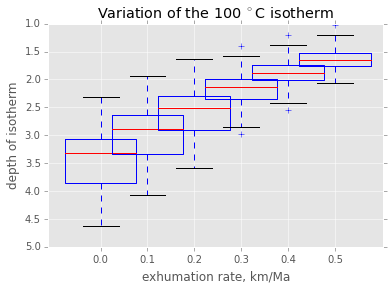

In [1553]:
fig = plt.figure()
ax = fig.add_subplot(111)
boxplot(isotherms2, positions=exhume_vals)
labels = exhume_vals
plt.xlim(-0.1,0.6)
ax.set_xticklabels(list((around(exhume_vals, decimals=1))))
plt.gca().invert_yaxis()
#xticks(range(0,0.5),labels, rotation=15)
xlabel('exhumation rate, km/Ma')
ylabel('depth of isotherm')
title('Variation of the 100 $^\circ$C isotherm')
#plt.savefig('isotherms_vs_uplift.png')

In [1511]:
#Estimate the geotherm
effective_geotherm2 = [abs(100./i) for i in isotherms2]

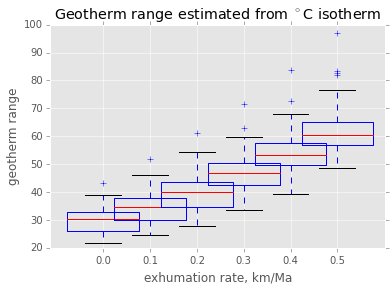

In [1554]:
fig = plt.figure()
ax = fig.add_subplot(111)
boxplot(effective_geotherm2, positions=exhume_vals)
labels = exhume_vals
plt.xlim(-0.1,0.6)
ax.set_xticklabels(list((around(exhume_vals, decimals=1))))
xlabel('exhumation rate, km/Ma')
ylabel('geotherm range')
title('Geotherm range estimated from $^\circ$C isotherm')
#plt.savefig('geotherm_vs_uplift.png')

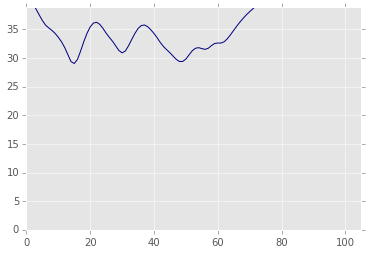

In [1501]:
###This is a very slapdash conversion from the pixel coordinates that our contours are in, to the DEM datum

CStest = plt.contour(flipud(temperatures3), levels=[100.], aspect='auto')
out = CStest.collections[0].get_paths()
arr1 = (((out[0].vertices[:,1])/(39./4.)) - (4.-zerolineelev)) 
arr2 = ((elev(out[0].vertices[:,0]) + mean_elv)/1e3)
arr3 = ((elev(out[0].vertices[:,0]) + mean_elv)/1e3) - (((out[0].vertices[:,1])/(39./4.)) - (4.-zerolineelev)) 


In [1502]:
#out[0].vertices[:,0]

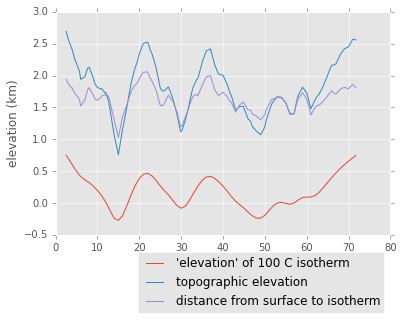

In [1563]:
fig = plt.figure()
ax = fig.add_subplot(111)
#plt.imshow(temperatures3)
plt.plot(out[0].vertices[:,0], arr1, label = "'elevation' of 100 C isotherm")
plt.plot(out[0].vertices[:,0], arr2, label = "topographic elevation")
plt.plot(out[0].vertices[:,0], arr3, label = "distance from surface to isotherm")
plt.legend(bbox_to_anchor=(1.0, -0.05))
ylabel('elevation (km)')
#xlabel('distance along profile')
#plt.savefig('depth_to_isotherm.png')

#Depth profiles